In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive/")
os.chdir("/content/drive/MyDrive/Watermark")
print(f">>>>>>>Current working directory is: {os.getcwd()}")

In [130]:
import numpy as np
from scipy import stats as st
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.decomposition import PCA
from PIL import Image, ImageFont, ImageDraw, ImageOps
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import normalize
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

In [131]:
def image_show(im_input):
  plt.imshow(cv2.cvtColor(im_input, cv2.COLOR_BGR2RGB))
  plt.axis("off")

In [132]:
def catalan_transform(pixel_group):
    n = pixel_group.shape[0]
    if n % 2 != 0:
        raise ValueError("Input matrix size must be even.")

    # Convert pixel_group to float64 to avoid overflow
    pixel_group = pixel_group.astype(np.float64)

    # Initialize the transformed group as zeros
    transformed_group = np.zeros_like(pixel_group)

    for i in range(0, n, 2):
        for j in range(0, n, 2):
            a = pixel_group[i, j]
            b = pixel_group[i, j + 1]
            c = pixel_group[i + 1, j]
            d = pixel_group[i + 1, j + 1]

            t0 = a
            t1 = b
            t2 = a + b
            t3 = (2 * a) + (2 * b) - c

            transformed_group[i, j] = t0
            transformed_group[i, j + 1] = t1
            transformed_group[i + 1, j] = t2
            transformed_group[i + 1, j + 1] = t3

    return transformed_group

In [133]:
def inverse_catalan_transform(pixel_group):
    n = pixel_group.shape[0]
    if n % 2 != 0:
        raise ValueError("Input matrix size must be even.")

    # Convert pixel_group to float64 to avoid overflow
    pixel_group = pixel_group.astype(np.float64)

    inverted_group = np.zeros_like(pixel_group)

    for i in range(0, n, 2):
        for j in range(0, n, 2):
            t0 = pixel_group[i, j]
            t1 = pixel_group[i, j + 1]
            t2 = pixel_group[i + 1, j]
            t3 = pixel_group[i + 1, j + 1]

            a = t0
            b = t1
            c = -t1 + t2
            d = (2 * t2) + t3

            inverted_group[i, j] = a
            inverted_group[i, j + 1] = b
            inverted_group[i + 1, j] = c
            inverted_group[i + 1, j + 1] = d

    return inverted_group

In [134]:
def NMF_Blocks(blocks, n_components=2):
  # Apply NMF to the transformed_blocks
  n_components = n_components  # You can adjust this based on your requirements
  model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
  W = model.fit_transform(blocks)
  H = model.components_

  return W, H

In [135]:
def reconstrucion(block_list, width, height):
  combined_blocks = np.zeros((height, width))

  for i in range(0, height, block_size):
    for j in range(0, width, block_size):
      block = np.array(block_list.pop(0)).astype(np.float64)
      combined_blocks[i:i + block_size, j:j + block_size] = block
  return combined_blocks

In [136]:
def reshuffle(array_data, seed_key):
  x_order = np.array([i for i in range(len(array_data))])
  #print(x_order)
  np.random.seed(seed_key)
  np.random.shuffle(x_order)
  # print(x_order)

  # x_reshuffled = np.zeros(len(x), dtype = "int64")
  x_reshuffled = np.copy(array_data)

  for index, original_index in enumerate(x_order):
    x_reshuffled[original_index] = array_data[index]

  return x_reshuffled

In [137]:
class ResolutionMisMatch(Exception):
    pass

In [138]:
def load_image_channel(image, channel_name):
  # Separate the carrier image into its Red, Green, and Blue channels
  height, width, channel = image.shape

  if height < 32:
    raise ResolutionMisMatch("Please use a photo with resolution of atleast 32x32")
  elif width < 32:
    raise ResolutionMisMatch("Please use a photo with resolution of atleast 32x32")
  elif channel != 3:
    raise ResolutionMisMatch("Please use a RGB photo")

  channel_names = ["blue", "green", "red"]
  index = channel_names.index(channel_name)
  channel = image[:, :, index]
  channel= channel/255.
  #height, width = channel.shape
  # print(f"Height: {height}, Width: {width}")
  return channel

In [139]:
def extract_blocks(image_channel, block_size):
  # Divide the image into 2x2 blocks
  block_size = block_size
  height, width = image_channel.shape
  blocks = [image_channel[i:i + block_size, j:j + block_size] for i in range(0, height, block_size) for j in range(0, width, block_size)]
  return blocks

In [140]:
def catalan_blocks(blocks, seed_key_catalan):
  # Apply Catalan Transform to each block
  transformed_blocks = [catalan_transform(block) for block in blocks]

  np.random.seed(seed_key_catalan)
  np.random.shuffle(transformed_blocks)

  return transformed_blocks

In [141]:
def NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W):
  transformed_blocks_NNMF = transformed_blocks[:length_watermarked_image_bits]
  # transformed_blocks_NNMF = np.array(transformed_blocks_NNMF)
  # transformed_blocks_NNMF[transformed_blocks_NNMF < 0] = 0

  # Apply NNMF to each block
  NMF_blocks = [NMF_Blocks(np.abs(block)) for block in transformed_blocks_NNMF]
  W, H = zip(*NMF_blocks)
  W = list(W)
  H = list(H)

  np.random.seed(seed_key_NMF_W)
  np.random.shuffle(W)
  return W, H

In [142]:
def generate_watermark_image(watermark_image_height, watermark_image_width, seed_key_water_mark, watermark_image_text):
  height_w = watermark_image_height*8
  width_w = watermark_image_width*8

  channels = 1

  img_blank = np.ones((height_w,width_w), dtype=np.uint8)*255
  text = watermark_image_text
  img_pil = Image.fromarray(img_blank.astype('uint8'))
  draw = ImageDraw.Draw(img_pil)

  fontsize = 1
  img_fraction = 1
  font = ImageFont.truetype('Arial.ttf', fontsize)

  while font.getsize(text)[1] < img_fraction*height_w:
    fontsize += 1
    font = ImageFont.truetype("Arial.ttf", fontsize)

  while font.getsize(text)[0] > img_fraction*width_w:
    fontsize -= 1
    font = ImageFont.truetype("Arial.ttf", fontsize)

  fontsize -= 1
  font = ImageFont.truetype("Arial.ttf", fontsize)

  _, _, w, h = draw.textbbox((0, 0), text, font=font)
  draw.text(((width_w-w)/2, -3+(height_w-h)/2), text, font=font, fill =0)
  img_pil = img_pil.resize((watermark_image_width, watermark_image_height))

  img_water_mark = np.array(img_pil).reshape(watermark_image_height, watermark_image_width)
  img_water_mark[img_water_mark < 200] = 0
  img_water_mark[img_water_mark >= 200] = 255
  # plt.imshow(img_water_mark, cmap='gray', vmin=0, vmax=255)
  # plt.axis("off")
  shuffled_watermark = np.copy(img_water_mark.flatten())
  np.random.seed(seed_key_water_mark)
  np.random.shuffle(shuffled_watermark)

  return img_water_mark, shuffled_watermark

In [143]:
def random_water_mark_gen(length_watermarked_image_bits, seed_key_water_mark):
  np.random.seed()
  reference_water_mark_bit = np.round(np.random.rand(length_watermarked_image_bits))
  reference_water_mark = [255 if bit==0 else 0 for bit in reference_water_mark_bit]

  random_water_mark = np.array(reference_water_mark)

  np.random.seed(seed_key_water_mark)
  np.random.shuffle(random_water_mark)

  return random_water_mark

In [144]:
def diff_max_gen(W, threshold, length_watermarked_image_bits):
  diff_max_range = length_watermarked_image_bits
  diff_max_list = []
  for block in W:
    max_v = []
    for W_row in block:
      W_row = list(W_row)
      max_v.append(max(W_row))
    max_v = sorted(max_v, reverse=True)
    diff = max_v[0] - max_v[1]
    diff_max_list.append(diff)

  sigma = sum(diff_max_list[:diff_max_range])/diff_max_range # Watermarking difference value

  return diff_max_list, sigma

In [145]:
def embedding_process(W_NNMF, combined_water_mark, diff_max_list, sigma):
  W = W_NNMF
  for index, pixel_value in enumerate(combined_water_mark):
    image_bit = 1 if pixel_value == 0 else 0
    block = W[index]
    max_index = np.unravel_index(block.argmax(), block.shape)
    max_value = block[max_index]
    min_index = np.unravel_index(block.argmin(), block.shape)
    min_value = block[min_index]

    if image_bit == 1:
      if diff_max_list[index] < np.max([sigma, threshold]):
        pass
      else:
        W[index][max_index] = np.max([0, max_value - threshold])
        # print("Modified max")
    else:
      W[index][min_index] = max_value - diff_max_list[index]
      # print("Modified min")
  return W

In [146]:
def feature_set_gen(W):
  feature_set = []
  for index, block in enumerate(W):
    block = W[index].flatten()
    # Standard deviation
    SD = np.std(block)

    # Entropy
    unique_elements, counts_elements = np.unique(block, return_counts=True)
    prob = counts_elements / len(block)
    en = [-1*p*np.log(p) for p in prob]
    Entropy = np.sum(en)

    Mean = np.mean(block)
    Variance = np.var(block)
    Mode = st.mode(block)[0]
    Median = np.median(block)
    Moment = st.moment(block, moment=2)
    Covariance = np.cov(block)
    Quartiles = np.quantile(block, [0.5])
    Kurtosis = st.kurtosis(block)
    Skewness = st.skew(block)
    Coff_1 = block[0]
    Coff_2 = block[1]
    Coff_3 = block[2]
    Coff_4 = block[3]

    features = [SD, Entropy, Mean, Variance, Mode, Median, Moment, Covariance, Quartiles, Kurtosis, Skewness, Coff_1, Coff_2, Coff_3, Coff_4]
    feature_set.append(features)

  feature_set = np.array(feature_set, dtype="float")
  feature_set[np.isnan(feature_set)] = 0

  features_reduced = PCA(n_components=10).fit_transform(feature_set)
  return features_reduced

In [147]:
def image_reconstruction(W, H, transformed_blocks, original_image, channel_name, seed_key_catalan, seed_key_NMF_W, length_watermarked_image_bits):
  height, width, _ = original_image.shape

  W = reshuffle(W, seed_key_NMF_W)

  transformed_blocks_retrived = []
  for w, h in zip(W,H):
    transformed_blocks_retrived.append(np.dot(w,h))

  transformed_blocks[:length_watermarked_image_bits] = transformed_blocks_retrived
  transformed_blocks_retrived = reshuffle(transformed_blocks, seed_key_catalan)

  original_blocks = [inverse_catalan_transform(block) for block in transformed_blocks_retrived]

  reconstructed_image_channel = reconstrucion(original_blocks, width, height)

  channel_names = ["blue", "green", "red"]
  index = channel_names.index(channel_name)

  reconstructed_image = np.copy(original_image)
  reconstructed_image[:, :, index] = reconstructed_image_channel * 255

  return reconstructed_image

In [148]:
def embedding_training(original_image,
              seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
              watermark_image_height, watermark_image_width,
              threshold, channel_name, block_size = 2
              ):

  length_watermarked_image_bits = watermark_image_height * watermark_image_width

  image_channel = load_image_channel(original_image, channel_name)
  blocks = extract_blocks(image_channel, block_size)
  transformed_blocks = catalan_blocks(blocks, seed_key_catalan)
  W, H = NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W)
  random_water_mark = random_water_mark_gen(length_watermarked_image_bits, seed_key_water_mark)
  diff_max_list, sigma = diff_max_gen(W, threshold, length_watermarked_image_bits)
  W_embedded = embedding_process(W, random_water_mark, diff_max_list, sigma)
  reconstructed_image = image_reconstruction(W_embedded, H, transformed_blocks, original_image, channel_name, seed_key_catalan, seed_key_NMF_W, length_watermarked_image_bits)

  return reconstructed_image, random_water_mark

In [149]:
def embedding(original_image,
              seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
              watermark_image_height, watermark_image_width, watermark_image_text,
              threshold, channel_name, block_size = 2
              ):

  length_watermarked_image_bits = watermark_image_height * watermark_image_width

  image_channel = load_image_channel(original_image, channel_name)
  blocks = extract_blocks(image_channel, block_size)
  transformed_blocks = catalan_blocks(blocks, seed_key_catalan)
  W, H = NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W)
  img_water_mark, shuffled_watermark = generate_watermark_image(watermark_image_height, watermark_image_width, seed_key_water_mark, watermark_image_text)
  diff_max_list, sigma = diff_max_gen(W, threshold, length_watermarked_image_bits)
  W_embedded = embedding_process(W, shuffled_watermark, diff_max_list, sigma)
  reconstructed_image = image_reconstruction(W_embedded, H, transformed_blocks, original_image, channel_name, seed_key_catalan, seed_key_NMF_W, length_watermarked_image_bits)

  return reconstructed_image, img_water_mark, shuffled_watermark

In [150]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        # x = torch.from_numpy(x)
        x = torch.tensor(x)
        y = 1 if self.targets[index] == 0 else 0
        y = torch.tensor(y)

        return x, y

    def __len__(self):
        return len(self.data)

In [170]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 100)
        self.layer2 = nn.Linear(100, 300)
        self.layer3 = nn.Linear(300,300)
        self.layer4 = nn.Linear(300,300)
        self.output = nn.Linear(300, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [152]:
def dataset_gen(image_list, watermark_list, seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
                watermark_image_height, watermark_image_width,
                threshold, channel_name, block_size = 2):
  length_watermarked_image_bits = watermark_image_height * watermark_image_width

  # generate train data
  targets = np.array([])
  features = np.array([])

  for indx, image in enumerate(image_list):
    original_image = cv2.imread(image)

    reconstructed_image, random_water_mark = embedding_training(original_image,
              seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
              watermark_image_height, watermark_image_width,
              threshold, channel_name, block_size = 2
              )

    image_channel = load_image_channel(reconstructed_image, channel_name = "blue")
    blocks = extract_blocks(image_channel, block_size)
    transformed_blocks = catalan_blocks(blocks, seed_key_catalan)
    W, _ = NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W)
    features_reduced = feature_set_gen(W)

    features = features_reduced if indx ==0 else np.vstack((features, features_reduced))
    targets = np.concatenate((targets, random_water_mark))

  # generate test data
  for indx, image_files in enumerate(zip(image_list, watermark_list)):
    original_image = cv2.imread(image_files[0])

    watermark_image_text = image_files[1]

    reconstructed_image, _, shuffled_watermark = embedding(original_image,
              seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
              watermark_image_height, watermark_image_width, watermark_image_text,
              threshold, channel_name, block_size = 2
              )

    image_channel = load_image_channel(reconstructed_image, channel_name = "blue")
    blocks = extract_blocks(image_channel, block_size)
    transformed_blocks = catalan_blocks(blocks, seed_key_catalan)
    W, _ = NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W)
    features_reduced = feature_set_gen(W)

    features = np.vstack((features, features_reduced))
    targets = np.concatenate((targets, shuffled_watermark))

  dataset = Dataset(features, targets)

  return dataset

In [185]:
def trainning_extractor_model(train_loader, batch_size, num_epochs):
  model = Model()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  loss_fn = nn.BCELoss()  # binary cross entropy
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model.to(device)

  for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")

    # Training loop
    print('Training')
    prog_bar = tqdm(train_loader, total = len(train_loader))
    total_loss = 0

    for _, data in enumerate(prog_bar):
      # take a batch
      X_batch = data[0].float().to(device)
      y_batch = data[1].float().unsqueeze(1).to(device)
      # forward pass
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()
      # print progress
      acc = (y_pred.round() == y_batch).float().mean()

      prog_bar.set_description(desc=f"Loss: {round(float(loss), 2)}, Acc: {round(float(acc), 2)}")

  torch.save(model, "watermark_DL.pth")
  return model

In [154]:
def extract_watermark(extractor_model, watermarked_image, channel_name,
                      seed_key_water_mark, seed_key_catalan, seed_key_NMF_W,
                      watermark_image_height, watermark_image_width,
                      block_size):
  length_watermarked_image_bits = watermark_image_height * watermark_image_width

  image_channel = load_image_channel(watermarked_image, channel_name)
  blocks = extract_blocks(image_channel, block_size)
  transformed_blocks = catalan_blocks(blocks, seed_key_catalan)
  W, _ = NNMF_blocks(transformed_blocks, length_watermarked_image_bits, seed_key_NMF_W)
  features_reduced = feature_set_gen(W)

  pred_pixel = []
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  extractor_model.to(device)
  extractor_model.eval()

  for feature in features_reduced:
    feature = torch.from_numpy(feature).float().to(device)
    y_pred_pixel = extractor_model(feature).cpu().round().detach().numpy()
    y_pred_pixel = 0 if y_pred_pixel == 1 else 255
    pred_pixel.append(y_pred_pixel)

  pred_pixel_reshuffled = reshuffle(pred_pixel, seed_key_water_mark)
  pred_pixel_original = np.array(pred_pixel_reshuffled[:length_watermarked_image_bits]).reshape(watermark_image_height,watermark_image_width)

  return pred_pixel_original

In [155]:
def test_accuracy(model, test_loader, batch_size):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  model.to(device)
  model.eval()

  accuracy = []

  for features, targets in test_loader:
      # take a batch
      features = features.float().to(device)
      targets = targets.float().unsqueeze(1).to(device)
      # forward pass
      y_pred = model(features)

      acc = (y_pred.cpu().round() == targets.cpu()).float().mean()
      accuracy.append(acc)

  print(f"Test accuracy is {round(np.mean(accuracy)*100, 2)}%")

In [156]:
# # Load the image
image_list = ["lenna.png", "plane.jpg", "bird.png"]
watermark_list = ["CUET", "CSE", "CUET"]
assert len(image_list) == len(watermark_list)
# define parameters
seed_key_catalan = 62
seed_key_NMF_W = 25
seed_key_water_mark = 107
seed_random_water_mark_gen = 12

watermark_image_height = 32*2
watermark_image_width = 64*2
threshold = 0.3 # watermark_embedding
block_size = 2
channel_name = "blue"

In [157]:
dataset = dataset_gen(image_list, watermark_list, seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
                watermark_image_height, watermark_image_width,
                threshold, channel_name, block_size)

batch_size = 512
test_data_split = 0.2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_data_split * dataset_size))

random_seed = 23
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
num_epochs = 55
model = trainning_extractor_model(train_loader, batch_size, num_epochs)

In [183]:
test_accuracy(model, test_loader, batch_size)

Test accuracy is 96.83%


Image name:lenna.png PSNR value for watermark image:18.2dB, SSIM value for watermark image:0.94
Image name:plane.jpg PSNR value for watermark image:18.06dB, SSIM value for watermark image:0.93
Image name:bird.png PSNR value for watermark image:18.64dB, SSIM value for watermark image:0.94


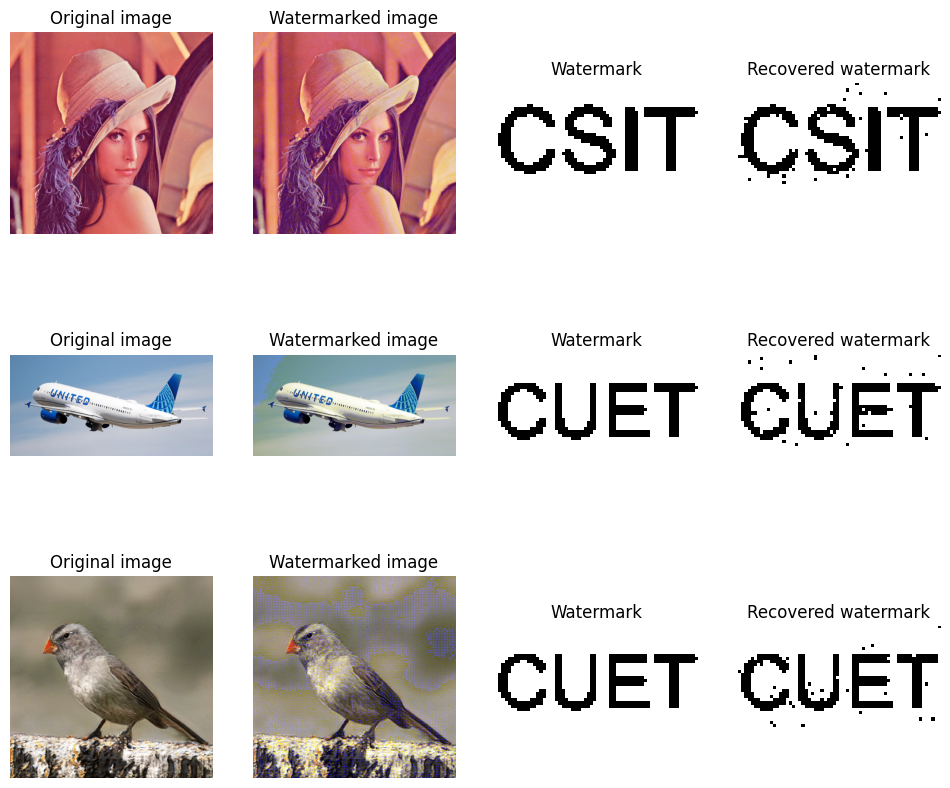

In [191]:
image_list = ["lenna.png", "plane.jpg", "bird.png"]
watermark_list = ["CSIT", "CUET", "CUET"]
assert len(image_list) == len(watermark_list)

fig, ax = plt.subplots(len(image_list), 4, figsize=(12,10), )

for indx, image_data in enumerate(zip(image_list, watermark_list)):
  original_image = cv2.imread(image_data[0])

  reconstructed_image, img_water_mark, shuffled_watermark = embedding(original_image,
              seed_key_catalan, seed_key_NMF_W, seed_key_water_mark,
              watermark_image_height, watermark_image_width, image_data[1],
              threshold, channel_name, block_size = 2
              )

  pred_pixel_original = extract_watermark(model, reconstructed_image, channel_name,
                      seed_key_water_mark, seed_key_catalan, seed_key_NMF_W,
                      watermark_image_height, watermark_image_width,
                      block_size)

  psnr_value = peak_signal_noise_ratio(img_water_mark, pred_pixel_original)
  ssim_value, _ = ssim(img_water_mark, pred_pixel_original, full=True, channel_axis=-1)
  print(f"Image name:{image_data[0]} PSNR value for watermark image:{round(psnr_value, 2)}dB, SSIM value for watermark image:{round(ssim_value, 2)}")

  ax[indx, 0].imshow(cv2.cvtColor(original_image , cv2.COLOR_BGR2RGB))
  ax[indx, 0].axis('off')
  ax[indx, 0].set_title('Original image')
  ax[indx, 1].imshow(cv2.cvtColor(reconstructed_image , cv2.COLOR_BGR2RGB))
  ax[indx, 1].axis('off')
  ax[indx, 1].set_title('Watermarked image')
  ax[indx, 2].imshow(img_water_mark, cmap='gray', vmin=0, vmax=255)
  ax[indx, 2].axis('off')
  ax[indx, 2].set_title('Watermark')
  ax[indx, 3].imshow(pred_pixel_original, cmap='gray', vmin=0, vmax=255)
  ax[indx, 3].axis('off')
  ax[indx, 3].set_title('Recovered watermark')

plt.show()